In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os
from keras.regularizers import l2
import pickle
import warnings
warnings.filterwarnings('ignore')


In [5]:
features_file = 'features.pkl'
labels_file = 'labels.pkl'
scaler_file = 'scaler.pkl'

# 检查是否已经有保存的特征文件
if os.path.exists(features_file) and os.path.exists(labels_file) and os.path.exists(scaler_file):
    # 直接加载保存的特征和标签
    with open(features_file, 'rb') as f:
        X = pickle.load(f)
    with open(labels_file, 'rb') as f:
        y = pickle.load(f)
    with open(scaler_file, 'rb') as f:
        scaler = pickle.load(f)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(y_train)
Y_test_encoded = label_encoder.transform(y_test)

In [17]:
def build_lstm_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(128,return_sequences=True ,input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(output_shape, activation='softmax'))
    return model

def train_lstm_model(X_train, Y_train, X_val, Y_val, batch_size=32, epochs=200):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), len(np.unique(Y_train)))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)
    return model, history

In [18]:
X_train_reshaped = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
X_test_reshaped = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# Train LSTM model
lstm_model, lstm_history = train_lstm_model(X_train_reshaped, Y_train_encoded, 
                                            X_test_reshaped, Y_test_encoded)

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1657 - loss: 3.0775 - val_accuracy: 0.2879 - val_loss: 2.9052
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3229 - loss: 2.8444 - val_accuracy: 0.2652 - val_loss: 2.6182
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3084 - loss: 2.5400 - val_accuracy: 0.2576 - val_loss: 2.2390
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3365 - loss: 2.1815 - val_accuracy: 0.2879 - val_loss: 1.9282
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3970 - loss: 1.9102 - val_accuracy: 0.4470 - val_loss: 1.7013
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5098 - loss: 1.6964 - val_accuracy: 0.5152 - val_loss: 1.5227
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5630 - loss: 1.4940 - val_accuracy: 0.4924 - val_loss: 1.3931
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6367 - loss: 1.3399 - val_accuracy: 0.6439 - 

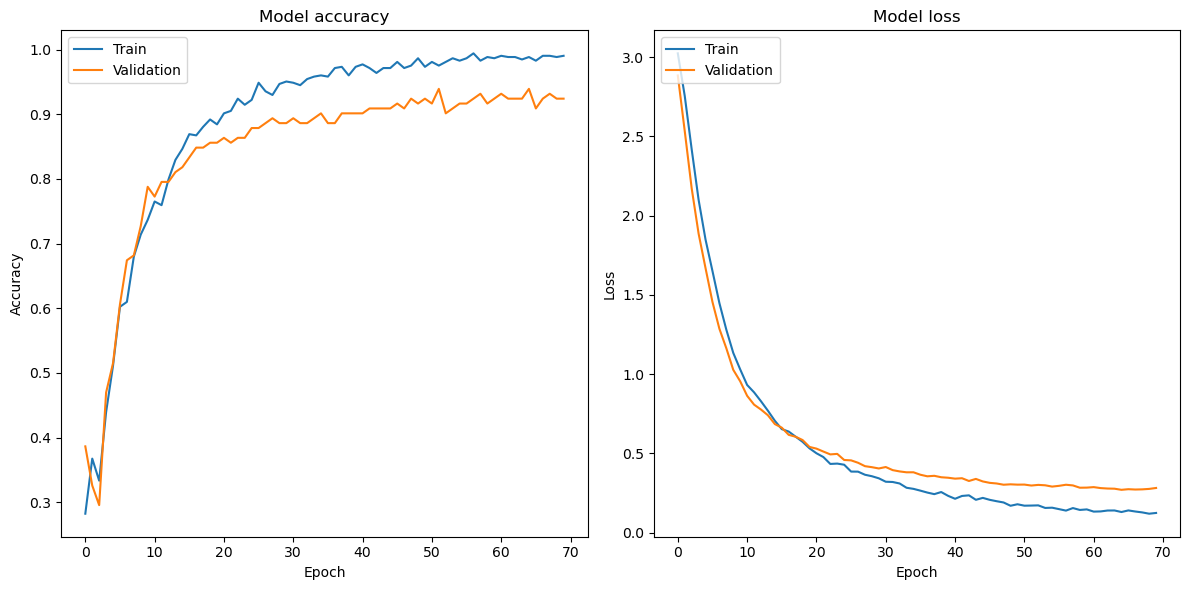

In [14]:
# Plot training and validation curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Testing Accuracy: 0.9318181818181818


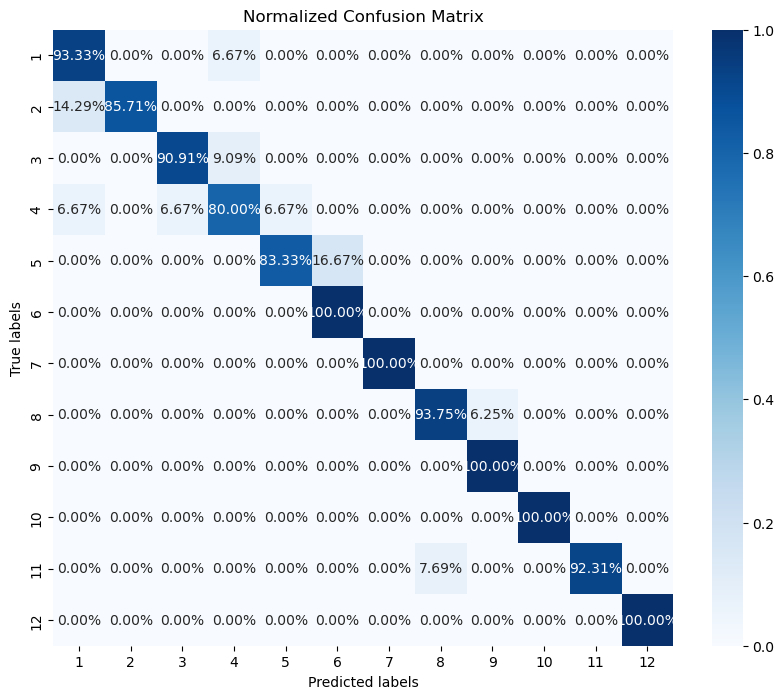

In [8]:
def evaluate_model(model, X_test, Y_test):
    Y_pred_prob = model.predict(X_test)
    Y_pred = np.argmax(Y_pred_prob, axis=1)
    testing_accuracy = accuracy_score(Y_test, Y_pred)
    print("Testing Accuracy:", testing_accuracy)
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    #print("Confusion Matrix:")
    #print(conf_matrix)
    
    # Normalize confusion matrix
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Display confusion matrix as heatmap with percentages
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    return testing_accuracy, conf_matrix

# Evaluate LSTM model
testing_accuracy, conf_matrix = evaluate_model(lstm_model, X_test_reshaped, Y_test_encoded)

In [19]:
import numpy as np
import pandas as pd
from scipy.signal import welch,savgol_filter
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import kurtosis, skew
# 平滑数据的函数
def savgol_filter_data(data, window_length=11, polyorder=2):
    return savgol_filter(data, window_length=window_length, polyorder=polyorder, axis=0)
warnings.filterwarnings('ignore')
def extract_time_domain_features(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    var = np.var(data, axis=0)
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    kurt = kurtosis(data, axis=0)   # 峰度
    skewness = skew(data, axis=0)   # 偏度
    rms = np.sqrt(np.mean(data**2, axis=0)) # 均方根
    energy = np.sum(data**2, axis=0) # 总能量
    return np.concatenate([mean, std, var, min_val, max_val, kurt,
                           skewness, rms,energy])
def extract_frequency_domain_features(data, fs=100):
    f, Pxx = welch(data, fs, nperseg=512)
    # 提取功率谱密度的特征
    mean_freq = np.mean(Pxx,axis=0)
    max_freq = np.max(Pxx,axis=0)
    min_freq = np.min(Pxx,axis=0)
    std_freq = np.std(Pxx,axis=0)
    var_freq = np.var(Pxx,axis=0)
    return np.concatenate([mean_freq, max_freq, min_freq, std_freq, var_freq])
def extract_features(df):
    # 提取前10秒的数据（假设每秒100个样本）
    sample_length = 1000  # 10秒 * 100样本/秒
    df = df.iloc[:sample_length]  # 仅保留前1000行
    
    # 提取加速度计和陀螺仪数据
    acc_data = df[['acc_x(g)', 'acc_y(g)', 'acc_z(g)']].values
    gyro_data = df[['gyro_x(dps)', 'gyro_y(dps)', 'gyro_z(dps)']].values
    
    smoothed_acc_data = np.apply_along_axis(savgol_filter_data, 0, acc_data)
    smoothed_gyro_data = np.apply_along_axis(savgol_filter_data, 0, gyro_data)

    # 提取时间域特征
    acc_time_features = extract_time_domain_features(smoothed_acc_data)
    gyro_time_features = extract_time_domain_features(smoothed_gyro_data)
    
    # 提取频域特征
    acc_freq_features = extract_frequency_domain_features(smoothed_acc_data)
    gyro_freq_features = extract_frequency_domain_features(smoothed_gyro_data)

    # 融合特征
    combined_features = np.concatenate([acc_time_features, gyro_time_features,
                                         acc_freq_features, gyro_freq_features])
    return combined_features
file_paths = [f'../../附件3/SY{i}.xlsx' for i in range(1, 31)]
person1_data = [pd.read_excel(file_path) for file_path in file_paths]
features = np.array([extract_features(df) for df in person1_data])
scaler = StandardScaler()
xx = scaler.fit_transform(features)
xxx = xx.reshape((xx.shape[0], 1, xx.shape[1]))
yy = lstm_model.predict(xxx)
Y_pred = np.argmax(yy, axis=1)
Y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


array([ 4,  0,  6, 10,  6,  9,  1,  5,  6,  9,  8,  6,  3,  2,  0,  0,  3,
        1,  7, 11,  5,  1,  7,  4,  1,  8,  7,  4,  5,  4], dtype=int64)